In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

from pathlib import Path

In [2]:
def extract_years(dates):
    # Extract the first and last years from a "dates_covered" string
    if pd.isna(dates):
        return (np.nan, np.nan)
    years = re.findall(r"\b\d{4}\b", str(dates))
    if len(years) < 2:
        return (np.nan, np.nan)
    return int(years[0]), int(years[1])

In [18]:
# Set paths 
root_p = Path("/Users/natashaclarke/winrepo/funders_project")
data_p = root_p / "data"
stats_p = data_p / "FundingAgencyStats - full_eu_breakdown_analysis.csv"
figures_p = root_p / "figures"
figures_p.mkdir(parents=True, exist_ok=True)

In [19]:
# Load data
df = pd.read_csv(stats_p)

In [20]:
df.columns

Index(['checked since 09/2025', 'researcher', 'category', 'country', 'funder',
       'label', 'data_type', 'dates_covered', 'findable', 'tabular',
       'data_downloadable', '>=3 years data', 'neuro_specific',
       'age_or_career_stage', 'gender', 'summary_funding', 'per_group_funding',
       'grant_duration', 'year_of_award', 'dei_eo_page', 'parental_leave',
       'english_data', 'report_all_applicants', 'total_score',
       'report_winners', 'age', 'career_stage', 'disability', 'ethnicity',
       'osf_file', 'notes'],
      dtype='object')

In [21]:
# Total unique countries
num_countries = df['country'].nunique()

# Total unique funders
num_funders = df['label'].nunique()

# How many funders have data
funder_max = df.groupby('label').agg({
    'findable': 'max',
}).reset_index()
num_funders_with_data = (funder_max['findable'] == 1).sum()

print(f"Countries: {num_countries}")
print(f"Funders total: {num_funders}")
print(f"Funders with data: {num_funders_with_data}")

Countries: 33
Funders total: 40
Funders with data: 35


In [22]:
# Get the frequency of each data type
data_type_counts = df['data_type'].value_counts().reset_index()

# Rename the columns for clarity
data_type_counts.columns = ['data_type', 'count']

# Calculate percentages
data_type_counts['percentage'] = (data_type_counts['count'] / data_type_counts['count'].sum()) * 100
data_type_counts

,data_type,count,percentage
0,annual_report,19,35.849057
1,tabular,13,24.528302
2,portal,10,18.867925
3,report,6,11.320755
4,list,5,9.433962


In [23]:
# Calculate the widest range of data available per funder
# Extract start and end of funding years
df[["start_year", "end_year"]] = (df["dates_covered"].apply(extract_years).apply(pd.Series))
df["start_year"] = df["start_year"].astype("Int64")
df["end_year"] = df["end_year"].astype("Int64")
df.sort_values("start_year").head()

,checked since 09/2025,researcher,category,country,funder,label,data_type,dates_covered,findable,tabular,...,total_score,report_winners,age,career_stage,disability,ethnicity,osf_file,notes,start_year,end_year
13,Y,NC,EU member,Denmark,Novo Nordisk Foundation,DK - Novo Nordisk Foundation (NNF),portal,1963-2026,1,0.0,...,6,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1963,2026
54,Y,DP,Schengen area,Switzerland,SNSF,CH - Swiss National Science Foundation (SNSF),tabular,1974-2025,1,1.0,...,13,1.0,0.0,1.0,0.0,0.0,/Switzerland - SNSF/All_grants.csv,NaN,1974,2025
31,Y,DP,EU member,Netherlands,NWO,NL - Dutch Research Council (NWO),portal,1993-2026,1,0.0,...,7,1.0,0.0,0.0,0.0,0.0,Projectendatabank | NWO,NaN,1993,2026
0,Y,PM,EU member,Austria,FWF,AT - Austrian Science Fund (FWF),tabular,1995-2025,1,1.0,...,11,1.0,0.0,1.0,0.0,0.0,/Austria - FWF/PI-projects....csv + annual rep...,NaN,1995,2025
24,Y,PM,EU member,Italy,PRIN,IT - Research Projects of National Relevance (...,list,1999-2022,1,0.0,...,10,1.0,0.0,1.0,0.0,0.0,"N/A, list online (see https://prin.mur.gov.it/)",NaN,1999,2022


In [24]:
cols = [
    "findable","tabular","data_downloadable",">=3 years data",
    "neuro_specific","age","gender","disability","ethnicity","career_stage",
    "summary_funding","per_group_funding","grant_duration","year_of_award",
    "dei_eo_page","parental_leave","english_data","report_all_applicants",
    "age_or_career_stage"
]

# Collapse funders to their max values
funder_max = df.groupby('label')[cols].max().reset_index()

# Compute percentages
percentages = (funder_max[cols].sum() / len(funder_max) * 100).sort_values(ascending=False)
percentages_df = percentages.reset_index()
percentages_df.columns = ['Measure', 'Percent_of_Funders']

percentages_df

,Measure,Percent_of_Funders
0,findable,87.5
1,>=3 years data,82.5
2,year_of_award,77.5
3,data_downloadable,72.5
4,english_data,72.5
5,summary_funding,70.0
6,age_or_career_stage,65.0
7,career_stage,62.5
8,gender,57.5
9,dei_eo_page,57.5


In [25]:
# keep only the row with the highest total_score per funder
best_df = df.sort_values("total_score", ascending=False).drop_duplicates("label")

In [26]:
def tier_color(score):
    if 1 <= score <= 8:
        return "peru"      
    elif 9 <= score <= 12:
        return "silver"    
    else:
        return "gold"

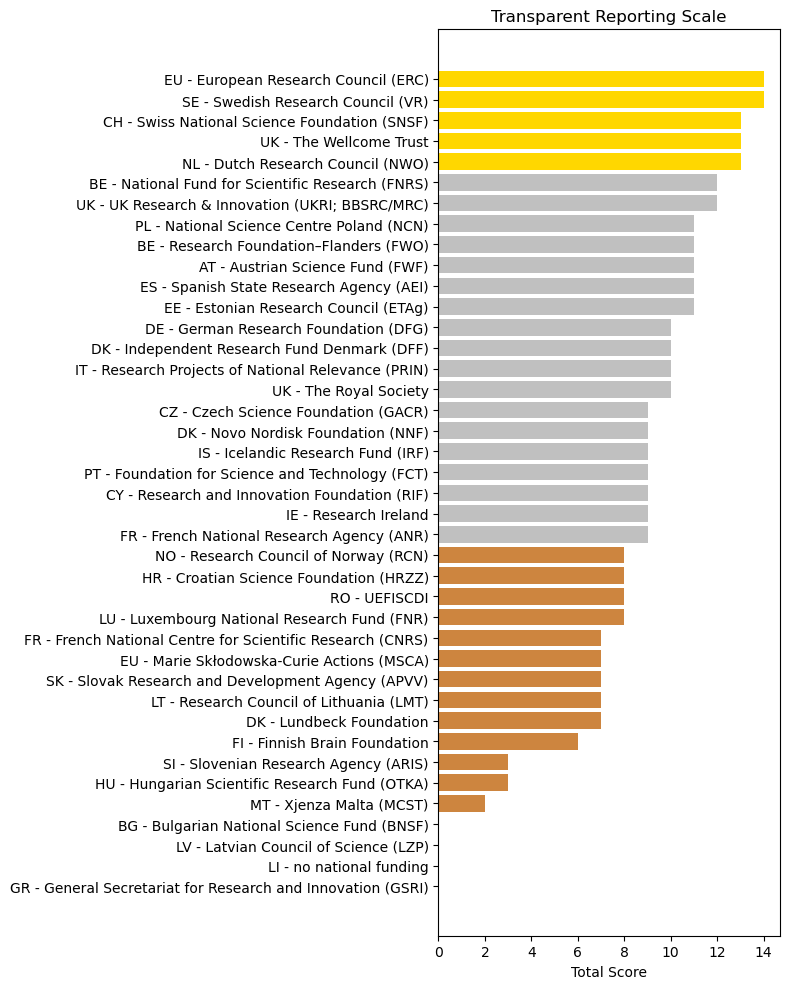

In [27]:
best_df = best_df.sort_values("total_score").dropna(subset=["label"])

# assign colors
best_df["color"] = best_df["total_score"].apply(tier_color)

plt.figure(figsize=(8, 10))
plt.barh(
    best_df["label"].astype(str),
    best_df["total_score"],
    color=best_df["color"]
)

plt.xlabel("Total Score")
plt.title("Transparent Reporting Scale")
plt.tight_layout()
plt.savefig(figures_p / "scale_results.png",dpi=300)
plt.show()

In [28]:
# Drop rows with no years
years_df = df.dropna(subset=["start_year"]).copy()

# Create the range of years for each funder
years_df["years_range"] = years_df.apply(lambda row: list(range(int(row["start_year"]), int(row["end_year"]) + 1)), axis=1)

# Expand into one row per year
years_df = years_df.explode("years_range").rename(columns={"years_range": "year"})

# Count unique funders per year
yearly_counts = years_df.groupby("year")["label"].nunique().reset_index()

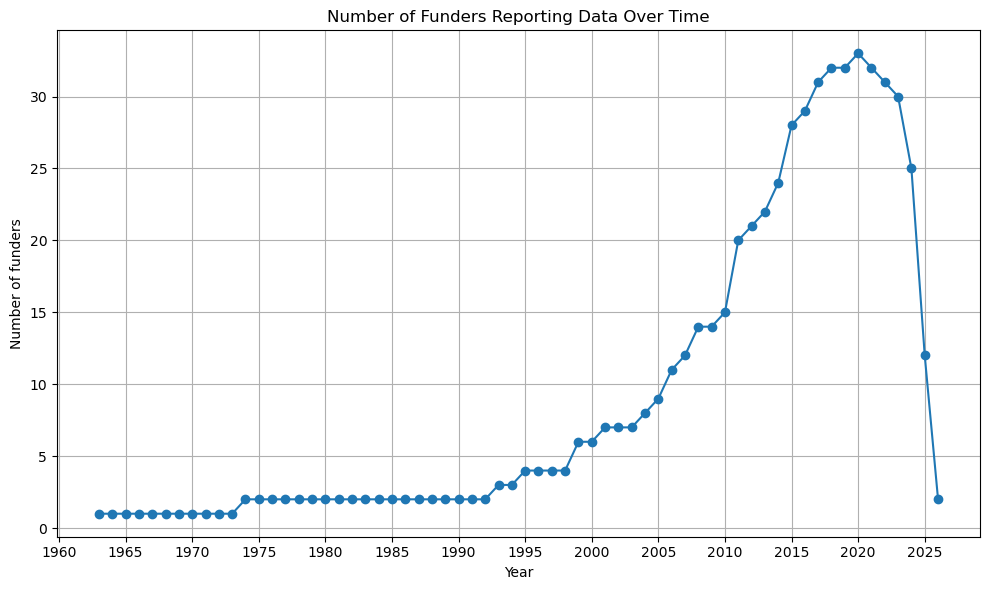

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["year"], yearly_counts["label"], marker="o")
plt.title("Number of Funders Reporting Data Over Time")
plt.xlabel("Year")
plt.ylabel("Number of funders")
plt.grid(True)
plt.xticks(ticks=range(1960, 2026, 5))
#plt.yticks(ticks=range(1, 16, 2))
plt.tight_layout()
plt.savefig(figures_p / "funding_over_time.png",dpi=300)
plt.show()

In [30]:
funders_per_country = df.groupby('country')['label'].nunique().reset_index() 
funders_per_country.columns = ['country', 'num_funders'] 
funders_per_country['country'] = funders_per_country['country'].replace('UK', 'United Kingdom') 
funders_per_country.head()

,country,num_funders
0,Austria,1
1,Belgium,2
2,Bulgaria,1
3,Croatia,1
4,Czech Republic,1


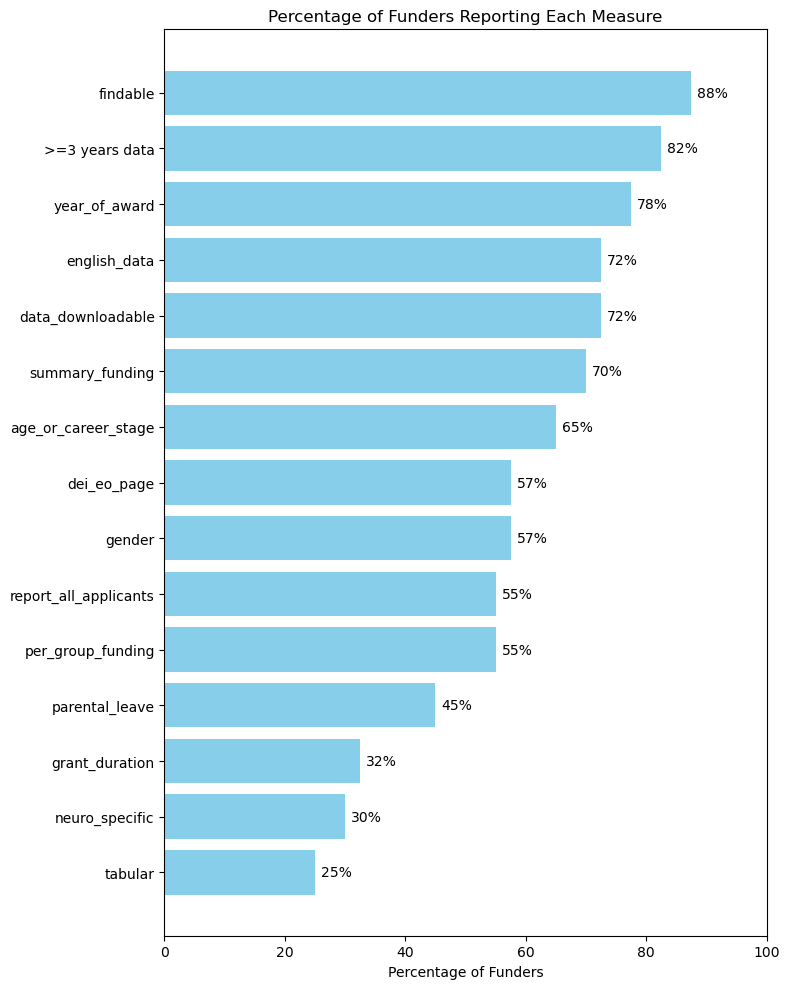

In [31]:
# create plot with a reduced number of columns

cols = [
    "findable","tabular","data_downloadable",">=3 years data",
    "neuro_specific","gender", "age_or_career_stage",
    "summary_funding","per_group_funding","grant_duration","year_of_award",
    "dei_eo_page","parental_leave","english_data","report_all_applicants",  
]

# Collapse funders to their max values
funder_max = df.groupby('label')[cols].max().reset_index()

# Compute percentages
percentages = (funder_max[cols].sum() / len(funder_max) * 100).sort_values(ascending=False)
percentages_df = percentages.reset_index()
percentages_df.columns = ['Measure', 'Percent_of_Funders']

percentages_df = percentages_df.sort_values("Percent_of_Funders", ascending=True)

plt.figure(figsize=(8, 10))
bars = plt.barh(percentages_df["Measure"], percentages_df["Percent_of_Funders"], color="skyblue")

# Add percentage labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,f"{width:.0f}%", va='center')

plt.xlabel("Percentage of Funders")
plt.title("Percentage of Funders Reporting Each Measure")
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig(figures_p / "percentages_plot.png",dpi=300)
plt.show()

In [34]:
# How much data is donwloaded?
dd = df[df["data_downloadable"] == 1].copy()

# Number of data records
num_records = len(dd)

# Number of unique funders with downloadable data
num_funders = dd["label"].nunique()

# Number of unique countries with downloadable data
num_countries = dd["country"].nunique()

num_records, num_funders, num_countries

(43, 29, 25)

In [33]:
# What is the data range for the downloaded data?
dd = df[df["data_downloadable"] == 1].copy()

# Earliest start year and latest end year
earliest_start = dd["start_year"].min()
latest_end = dd["end_year"].max()

print(f"Earliest start year: {earliest_start}")
print(f"Latest end year: {latest_end}")

Earliest start year: 1974
Latest end year: 2025
